In [2]:
import io
import param
import panel as pn
import pandas as pd
import csv
import numpy as np
import os
import sys
import ipywidgets as ipw
import time
import plotly.express as px
import plotly.graph_objects as go
from scipy.optimize import curve_fit
from plotly.subplots import make_subplots
from pathlib import Path
import pickle
import logging
import traceback
import copy
import FiberClass as fc


#current obj version
current_version = 3
pn.extension('terminal', notifications = True, sizing_mode = 'stretch_width')
pn.extension('plotly')
pn.extension(loading_spinner='arcs', loading_color='#00aa41')
#Dictionary of fiber objects
fiber_objs = {}
#Dataframe of object's info
fiber_data = pd.DataFrame(columns = ['Fiber #', 
                                     'Animal #', 
                                     'Exp. Date',
                                     'Exp. Start Time', 
                                     'Filename',
                                     'Behavior File'])

df = pd.DataFrame()

NotificationArea()

NotificationArea()

NotificationArea()

In [3]:
# ----------------------------------------------------- # 
#Start of GUI functions
# Read fpho data
def run_read_csv(event):
    """
    Reads in selected file from fpho_input widget
    and stores it in a global df.
    
    Parameters
    ----------
    event : int
        NOT USED. Number of times button has been clicked. 
    
    Returns
    ----------
    None
    """
    value = fpho_input.value
    global df
    try:
        string_io = io.StringIO(value.decode("utf8"))
        df = pd.read_csv(string_io) #Read into dataframe
        if not df.empty:
            upload_button.disabled = False # Enables create obj button
            pn.state.notifications.success('Your file has been loaded',
                                           duration = 4000)
            print('Your photometry file has been successfully loaded')
    except AttributeError:
        upload_button.disabled = False # Enables create obj button
        print("Make sure you choose a file")
        return
    except PermissionError:
        upload_button.disabled = False # Enables create obj button
        print("You do not have permission to access this file")
        return

# Create fpho object
def run_init_fiberobj(event):
    """
    Transforms user input from the GUI and calls fiber_object constructor.
    Creates a new object and adds that object's information to several
    places inside the GUI.
    
    Parameters
    ----------
    event : int
        NOT USED. Number of times button has been clicked. 
    
    Returns
    ----------
    None
    """
    filename = fpho_input.filename
    obj_name = input_1.value
    global df
    illegal_chars = "#<>%&{}\/!$ ?*+`|!:'@="
    for char in illegal_chars:
        obj_name = obj_name.replace(char, "_")
    if npm_format.value:
        fiber_num = input_2.value
    else:
        fiber_num = None
    animal_num = input_3.value_input
    exp_date = input_4.value_input
    exp_time = input_5.value_input
    start_time = input_6.value #looking for better name
    stop_time = input_7.value #looking for better name
    
     #Add input params to list for initialization
    input_params = []
    input_params.extend([obj_name, fiber_num, animal_num,
                         exp_date, exp_time, start_time, stop_time, filename])
    if (input_params[0] in fiber_objs):
        pn.state.notifications.error(
            'Error: Please check logger for more info', duration = 4000)
        print('There is already an object with this name')
        return
    try: 
        df
    except NameError:
        pn.state.notifications.error(
        'Error: Please check logger for more info', duration = 4000)
        print('Please load or reload your file with the "Read CSV" button')  
        return
    except IOError:
        pn.state.notifications.error(
            'Error: Please check logger for more info', duration = 4000)
        print('There was a problem reading the dataframe...try again')
        return
    try:
        #Add to dict if object name does not already exist
        new_obj = fc.FiberObj(df, input_params[0], input_params[1],
                              input_params[2], input_params[3],
                              input_params[4], input_params[5], 
                              input_params[6], input_params[7])    
        # Garbage collection
        # Releases memory for next instance
        del df
    except KeyError:
        logger.error(traceback.format_exc())
        pn.state.notifications.error(
            'Error: Please check logger for more information', duration = 4000)  
        print('It looks like theres something wrong with the format of your file')
        return
    except IndexError:
        logger.error(traceback.format_exc())
        pn.state.notifications.error(
            'Error: Please check logger for more information', duration = 4000)  
        print('Are you sure there are ', input_params[1], ' fibers in this file')
        return
    except Exception as e:
        logger.error(traceback.format_exc())
        pn.state.notifications.error(
            'Error: Please check logger for more information', duration = 4000)   
        return
    except ValueError:
        logger.error(traceback.format_exc())
        pn.state.notifications.error(
            'Error: Please check logger for more information', duration = 4000)
        print('Dataframe is empty. Please ensure a new csv has been imported')
        return
    #adds new obj to the dict
    fiber_objs[input_params[0]] = new_obj
    pn.state.notifications.success('Created ' + input_params[0] +
                                   ' object!', duration = 4000)
    #Adds to relevant info to dataframe
    fiber_data.loc[input_params[0]] = ([input_params[1], 
                                        input_params[2],
                                        input_params[3], 
                                        input_params[4],
                                        input_params[7],
                                        'NaN'])
    info_table.value = fiber_data
    existing_objs = fiber_objs
    
    #Updates selectors with new objects
    update_obj_selectas(existing_objs)
    last_filename = fpho_input.filename
    last_file = fpho_input.value
    return

# Upload pickled object files
def run_upload_fiberobj(event):
    """
    Unpickles saved objects and adds those objects' information to several
    places inside the GUI.

    Parameters
    ----------
    event : int
        NOT USED. Number of times button has been clicked. 

    Returns
    ----------
    None
    """
    filenames = upload_pkl_selecta.value
    # list of pickle objects to create
    pkl_objs = []
    # Read files and prepare for upload
    for file in filenames:
        try:
            temp_obj = pd.read_pickle(file)
            if temp_obj.obj_name in fiber_objs.keys():
                continue
            else:
                fiber_objs[temp_obj.obj_name] = temp_obj # Add obj to info table
                pkl_objs.append(temp_obj)
        except FileNotFoundError:             
            pn.state.notifications.error(
                'Error: Please check logger for more info',
                duration = 4000)
            print(file + ' could not be uploaded.' + 
                  ' You can only upload pickles located in the FiberPho_Main folder.')
            continue
        except EOFError:                    
            pn.state.notifications.error(
                'Error: Please check logger for more info', duration = 4000)
            print("Error uploading " + file + ". Ensure this is a valid .pkl file")
            continue
        if not hasattr(temp_obj, 'version') or temp_obj.version != current_version:
            pn.state.notifications.error(
            'Warning: Please check logger for more info', duration = 4000)
            print(temp_obj.obj_name + " is out of date. " + 
                  "It may cause problems in certain functions")

    # Read pickles into objects
    for obj in pkl_objs:
        try:
            fiber_data.loc[obj.obj_name] = ([obj.fiber_num,
                                          obj.animal_num,
                                          obj.exp_date,
                                          obj.exp_time,
                                          obj.filename,
                                          obj.beh_filename])
            info_table.value = fiber_data # Update info table with new obj data
            pn.state.notifications.success('Uploaded ' + obj.obj_name
                                   + ' object!', duration = 4000)
        except Exception as e:
            pn.state.notifications.error(
                'Error: Please check logger for more info', duration = 4000)
            logger.error(traceback.format_exc())
            print("There was an issue adding " + obj.obj_name +
                  "'s information to the table.")

    # Updates all cards with new objects
    existing_objs = fiber_objs
    update_obj_selectas(existing_objs)
    # Clear selecta values
    upload_pkl_selecta.value.clear()
    # Clear pkls from list
    pkl_objs.clear()
    return

# Combine two objects into one
def run_combine_objs(event):
    """
    Creates a new objects by combining data from two existing objects.
    
    Parameters
    ----------
    event : int
        NOT USED. Number of times button has been clicked. 
    
    Returns
    ----------
    None
    """
    obj1 = fiber_objs[combine_obj_selecta1.value]
    obj2 = fiber_objs[combine_obj_selecta2.value]
    obj_name = combine_obj_name.value 
    combine_type = combine_type_selecta.value
    time_adj = combine_time.value
    new_obj = copy.deepcopy(obj1)
    
    if obj_name in fiber_objs:
        pn.state.notifications.error(
            'Error: Please check logger for more info', duration = 4000)
        print('There is already an object with this name')
        return
    
    try:
        new_obj.combine_objs(obj2, obj_name,
                             combine_type, time_adj)
                                 
    except KeyError:
        print('key error')
        return
    fiber_objs[new_obj.obj_name] = new_obj
    #Adds to relevant info to dataframe
    fiber_data.loc[new_obj.obj_name] = ([new_obj.fiber_num, 
                                        new_obj.animal_num,
                                        new_obj.exp_date, 
                                        new_obj.exp_time,
                                        new_obj.filename,
                                        new_obj.beh_filename])
    info_table.value = fiber_data
    existing_objs = fiber_objs
    #Updates selectors with new objects
    update_obj_selectas(existing_objs)
    pn.state.notifications.success('Created ' + new_obj.obj_name +
                                   ' object!', duration = 4000)
    return
    
# # Deletes selected object 
def run_delete_fiberobj(event):
    """
    Deletes selected fiber objects.
    
    Parameters
    ----------
    event : int
        NOT USED. Number of times button has been clicked. 
    
    Returns
    ----------
    None
    """
    for obj in delete_obj_selecta.value:
        try:
            del fiber_objs[obj]
        except Exception as e:
            logger.error(traceback.format_exc())
            pn.state.notifications.error(
                'Error: Please check logger for more info', duration = 4000)
            print("Error: Cannot delete " + obj + ", please try again.")
            continue
        fiber_data.drop([obj], axis = 0, inplace = True)
    info_table.value = fiber_data
    existing_objs = fiber_objs
    # Updates all cards with new objects
    update_obj_selectas(existing_objs)
    return

# Saves selected object to pickle file
def run_save_fiberobj(event):
    """
    Pickles and saves selected fiber objects.
    
    Parameters
    ----------
    event : int
        NOT USED. Number of times button has been clicked. 
    
    Returns
    ----------
    None
    """
    for obj in save_obj_selecta.value:
        try:
            temp = fiber_objs[obj]
            if os.path.exists(temp.obj_name + ".pickle"):
                pn.state.notifications.error(
                    'Error: Please check logger for more info', duration = 4000)
                logger.error(traceback.format_exc())
                print("Error: This filename already exists, please try again.")
                return
            else:
                temp.version = current_version
                with open(obj + '.pickle', 'wb') as handle:
                    pickle.dump(temp, handle)
                pn.state.notifications.success('# ' + temp.obj_name
                                               + ' pickled successfully',
                                               duration = 4000)
                print(temp.obj_name + " saved at: " + os.path.abspath(""))
        except Exception as e:
            pn.state.notifications.error(
                'Error: Please check logger for more info', duration = 4000)
            logger.error(traceback.format_exc())
            print("Error: Cannot save object, please try again.")
            continue
    return
        
# Creates raw plot pane
def run_plot_traces(event):
    """
    Displays plots of photometry data from selected objects.
    
    Parameters
    ----------
    event : int
        NOT USED. Number of times button has been clicked. 
    
    Returns
    ----------
    None
    """
    # .value param to extract variables properly
    selected_objs = obj_selecta.value
    #For len of selected objs, create and plot raw signal graph
    for objs in selected_objs:
        temp = fiber_objs[objs]
        #Creates pane for plotting
        plot_pane = pn.pane.Plotly(height = 300)
        #Sets figure to plot variable
        try:
            plot_pane.object = temp.plot_traces() 
            plot_raw_card.append(plot_pane) #Add figure to template
            if save_pdf_rawplot.value:
                pdf_name = temp.obj_name + "_raw_data"
                save_plot(pdf_name, plot_pane.object)
        except Exception as e:
            logger.error(traceback.format_exc())
            pn.state.notifications.error(
                'Error: Please check logger for more info', duration = 4000)
            continue
    return
             
# Creates normalize signal pane
def run_normalize_a_signal(event):
    """
    Normalizes photometry data from selected objects and
    displays plots of the normalization process.
    
    Parameters
    ----------
    event : int
        NOT USED. Number of times button has been clicked. 
    
    Returns
    ----------
    None
    """
    # .value param to extract variables properly
    selected_objs = norm_selecta.value
    #For len of selected objs, create and plot raw signal graph
    for objs in selected_objs:
        temp = fiber_objs[objs]
        #Creates pane for plotting
        plot_pane = pn.pane.Plotly(height = 900) 
        #Sets figure to plot variable
        try:
            plot_pane.object = temp.normalize_a_signal(pick_signal.value, pick_reference.value,
                                          biexp_thres.value, linfit_type.value)
            norm_sig_card.append(plot_pane) #Add figure to template
            if save_pdf_norm.value:
                pdf_name = objs + '_' + pick_signal.value + "_normalized"
                save_plot(pdf_name, plot_pane.object)
        except Exception as e:
            logger.error(traceback.format_exc())
            pn.state.notifications.error(
                'Error: Please check logger for more info', duration = 4000)
            continue  
    return
        
#Read behavior data
def run_import_behavior_data(event):
    """
    Adds behavior data from a file to the selected fiber object.
    
    Parameters
    ----------
    event : int
        NOT USED. Number of times button has been clicked. 
    
    Returns
    ----------
    None
    """
    selected_obj = behav_selecta.value
    obj = fiber_objs[selected_obj]
    try:
        behav = behav_input.value
        filename = behav_input.filename
        file = behav.decode("utf8")
        header_idx = file.find('Behavior')
        header_line = file[:header_idx].count('\n')            
        beh_data = pd.read_csv(io.StringIO(file), header=header_line)  # starts at data
        obj.import_behavior_data(beh_data, filename)
        fiber_data.loc[obj.obj_name, 'Behavior File'] = obj.beh_filename
        info_table.value = fiber_data
        pn.state.notifications.success('Uploaded Behavior data for '
                                       + obj.obj_name, duration = 4000)
    except FileNotFoundError:
            print("Could not find file: " + BORIS_filename)
            pn.state.notifications.error(
            'Error: Please check logger for more info', duration = 4000)
    except PermissionError:
            print("Could not access file: " + BORIS_filename)
            pn.state.notifications.error(
            'Error: Please check logger for more info', duration = 4000)
    except Exception as e:
        logger.error(traceback.format_exc())
        pn.state.notifications.error(
            'Error: Please check logger for more info', duration = 4000)
        return
    return
                
#Plot behavior on a full trace
def run_plot_behavior(event): 
    """
    Displays plots of photometry data with behavior
    data overlaid as colored rectangles.
    
    Parameters
    ----------
    event : int
        NOT USED. Number of times button has been clicked. 
    
    Returns
    ----------
    None
    """
    selected_objs = plot_beh_selecta.value
    #For len of selected objs, create and plot behavior data
    for objs in selected_objs:
        temp = fiber_objs[objs]
        # if temp.beh_file is None: # Bug: Plot behavior still runs even without behavior file
        #Sets figure to plot variable
        try:
            plots = temp.plot_behavior(behavior_selecta.value,
                       channel_selecta.value)
            for i, plot in enumerate(plots):
                        #Creates pane for plotting
                plot_pane = pn.pane.Plotly(height = 500) 
                plot_pane.object =  plot
                plot_beh_card.append(plot_pane) #Add figure to template
                if save_pdf_beh.value:
                    pdf_name = objs + '_' + channel_selecta.value[i] + "_behavior_plot"
                    save_plot(pdf_name, plot_pane.object)
        except Exception as e:
            logger.error(traceback.format_exc())
            pn.state.notifications.error(
                'Error: Please check logger for more info', duration = 4000)
            continue
    return
  
#Plot Peri-event time series of an event
def run_plot_PETS(event): 
    """
    Displays peri-event time series plots for each
    selected object, channel and behavior combination. 
    
    Parameters
    ----------
    event : int
        NOT USED. Number of times button has been clicked. 
    
    Returns
    ----------
    None
    """
    selected_objs = PETS_selecta.value
    baseline_vals = np.array([baseline_start.value, baseline_end.value])
    # How user would like to apply the baseline window input
    baseline_option = baseline_selecta.value
    #For len of selected objs, create and plot zscores
    for beh in PETS_beh_selecta.value:
        for objs in selected_objs:
            temp = fiber_objs[objs]
            for channel in zchannel_selecta.value:
                #Creates pane for plotting
                plot_pane = pn.pane.Plotly(height = 500) 
                #Sets figure to plot variable
                try:
                    plot_pane.object = temp.plot_PETS(channel, beh, 
                                                        time_before.value, 
                                                        time_after.value, 
                                                        baseline_vals, 
                                                        baseline_option,
                                                        first_trace.value,
                                                        last_trace.value,
                                                        show_every.value,
                                                        save_csv.value,
                                                        percent_bool.value) 
                    PETS_card.append(plot_pane) #Add figure to template
                    if save_pdf_PETS.value:
                        pdf_name = objs + "_" + beh + "_" + channel + "_PSTH"
                        save_plot(pdf_name, plot_pane.object)
                except Exception as e:
                    logger.error(traceback.format_exc())
                    pn.state.notifications.error(
                        'Error: Please check logger for more info', duration = 4000)
                    continue

    return

def run_peak_finding(event): 
    """
    Displays time series plots with identified peaks
    for each selected object, and channel combination. 
    
    Parameters
    ----------
    event : int
        NOT USED. Number of times button has been clicked. 
    
    Returns
    ----------
    None
    """
    selected_objs = peak_selecta.value
    start_time = peak_start_time.value
    end_time = peak_end_time.value
    width_range = peak_width_slider.value
    for objs in selected_objs:
        temp = fiber_objs[objs]
        for channel in peak_channel_selecta.value:
            #Creates pane for plotting
            plot_pane = pn.pane.Plotly(height = 500) 
            #Sets figure to plot variable
            try:
                plot_pane.object = temp.peak_finding(channel,
                                                    start_time, end_time, 
                                                    width_range,
                                                    save_peak_data.value) 
                peak_card.append(plot_pane) #Add figure to template
                if save_peak_pdf.value:
                    pdf_name = objs + "_" + channel + "peaks"
                    save_plot(pdf_name, plot_pane.object)
            except Exception as e:
                logger.error(traceback.format_exc())
                pn.state.notifications.error(
                    'Error: Please check logger for more info', duration = 4000)
                continue

    return                
# Runs the pearsons correlation coefficient
def run_pearsons_correlation(event):
    """
    Displays a plot showing the pearson's correlation between
    the selected channels during a specified time period.
    
    Parameters
    ----------
    event : int
        NOT USED. Number of times button has been clicked. 
    
    Returns
    ----------
    None
    """
    try:
        name1 = pearsons_selecta1.value
        name2 = pearsons_selecta2.value
        obj1 = fiber_objs[name1]
        obj2 = fiber_objs[name2]
        channel1 = channel1_selecta.value
        channel2 = channel2_selecta.value
        start = pears_start_time.value
        end = pears_end_time.value
        #Creates pane for plot
        plot_pane = pn.pane.Plotly(height = 300) 
        plot_pane.object = obj1.pearsons_correlation(obj2,
                                                     channel1, channel2,
                                                     start, end)
        pearsons_card.append(plot_pane) #Add figure to template
        if save_pdf_time_corr.value:
            pdf_name = (name1 + '_' + channel1 + '_and_' + 
                        name2 + '_' + channel2 + "_correlation")
            save_plot(pdf_name, plot_pane.object)
    except ValueError:
        return
    except Exception as e:
        logger.error(traceback.format_exc())
        pn.state.notifications.error(
            'Error: Please check logger for more info', duration = 4000)
        return
    return

def run_beh_specific_pearsons(event):
    """
    Displays a plot showing the pearson's correlation between the selected 
    channels during time periods where a specific behavior is occuring.
    
    Parameters
    ----------
    event : int
        NOT USED. Number of times button has been clicked. 
    
    Returns
    ----------
    None
    """
    for behavior in beh_corr_behavior_selecta.value:
        name1 = beh_corr_selecta1.value
        name2 = beh_corr_selecta2.value
        obj1 = fiber_objs[name1]
        obj2 = fiber_objs[name2]
        channel1 = beh_corr_channel_selecta1.value
        channel2 = beh_corr_channel_selecta2.value
        #Creates pane for plot
        plot_pane = pn.pane.Plotly(height = 300)
        try:
            plot_pane.object = obj1.behavior_specific_pearsons(obj2,
                                                               channel1,
                                                               channel2,
                                                               behavior)
            beh_corr_card.append(plot_pane) #Add figure to template 
            if save_pdf_beh_corr.value:
                pdf_name = (name1 + '_' + channel1 + '_and_' + 
                            name2 + '_' + channel2 + '_' + 
                            behavior + "_correlation")
                save_plot(pdf_name, plot_pane.object)
        except Exception as e:
            logger.error(traceback.format_exc())
            pn.state.notifications.error(
                'Error: Please check logger for more info', duration = 4000)
            continue 
    return

def run_download_results(event):
    """
    Creates a .csv file with results from all selected objects
    for each selected analysis type.
    
    Parameters
    ----------
    event : int
        NOT USED. Number of times button has been clicked. 
    
    Returns
    ----------
    None
    """
    filename = output_name.value
    illegal_chars = "#<>%&{}\/!$ ?*+`|!:'@="
    for char in illegal_chars:
        filename = filename.replace(char, "_")
    for types in result_type_selecta.value:
        results = pd.DataFrame()
        try:
            if types == 'PETS Results':
                results = pd.concat([fiber_objs[name].PETS_results
                                    for name in results_selecta.value],
                                    ignore_index=True)
                results.to_csv(filename + '_PETS_results.csv', mode = 'x')
                pn.state.notifications.success(
                    'PETS Results Saved', duration = 4000)
                print("PETS results saved at: " + os.path.abspath(""))
            if types == 'Peak Finding Results':
                results = pd.concat([fiber_objs[name].peak_results
                                    for name in results_selecta.value],
                                    ignore_index=True)
                results.to_csv(filename + '_peak_results.csv', mode = 'x')
                pn.state.notifications.success(
                    'Peak Finding Results Saved', duration = 4000)
                print("Peak Finding results saved at: " + os.path.abspath(""))
            if types == 'Correlation Results':
                results = pd.concat([fiber_objs[name].correlation_results
                                    for name in results_selecta.value],
                                    ignore_index=True)
                results.to_csv(filename + '_correlation_results.csv', mode = 'x')
                pn.state.notifications.success(
                    'Correlation Results Saved', duration = 4000)
                print("Correlation results saved at: " + os.path.abspath(""))
            if types == 'Behavior Specific Correlation Reuslts':
                results = pd.concat([fiber_objs[name].beh_corr_results
                                    for name in results_selecta.value],
                                    ignore_index=True)
                results.to_csv(filename + '_behavior_correlation_results.csv', mode = 'x')
                pn.state.notifications.success(
                    'Behavior Correlation Results Saved', duration = 4000)
                print("Behavior correlation results saved at: " + os.path.abspath(""))
        except FileExistsError:
            pn.state.notifications.error(
                'Error: ' + types + ' could not be saved. Check logger for more info',
                duration = 4000)
            print('A file with this name already exists. Please change the output filename')
        except Exception as e:
            logger.error(traceback.format_exc())
            pn.state.notifications.error(
                'Error: ' + types + ' could not be saved. Check logger for more info',
                duration = 4000)
            continue
    return
            
# Convert alternative behavior data to boris 
def run_convert_alt_beh(event):
    """
    Converts a alternative format behavior .csv file to the boris format.
    
    Parameters
    ----------
    event : int
        NOT USED. Number of times button has been clicked. 
    
    Returns
    ----------
    None
    """
    file = alt_beh_input.value
    name = alt_beh_input.filename
    selected_obj = behav_selecta.value
    obj = fiber_objs[selected_obj]
    if file:
        try:
            string_io = io.StringIO(file.decode("utf8"))
            #Read into dataframe
            alt_beh_file = pd.read_csv(string_io) 
        except FileNotFoundError:
            print("Could not find file: " + alt_beh_input.filename)
            return
        except PermissionError:
            print("Could not access file: " + alt_beh_input.filename)
            return
    if not alt_beh_file.empty:
        try:
            beh_data = fc.alt_to_boris(alt_beh_file, time_unit.value, beh_false.value,
                                       time_between_bouts.value)
            obj.import_behavior_data(beh_data, name)
            fiber_data.loc[obj.obj_name, 'Behavior File'] = obj.beh_filename
            info_table.value = fiber_data
            pn.state.notifications.success('Uploaded Behavior data for '
                                       + obj.obj_name, duration = 4000)
        except Exception as e:
            logger.error(traceback.format_exc())
            pn.state.notifications.error(
                'Error: Please check logger for more info', duration = 4000)
    else:
        print('Error reading file')
    return
#End of GUI Functions
# ----------------------------------------------------- # 

#Saves plot as pdf.
def save_plot(graph_name, fig):
    """
    Takes in a filename and a fig and saves that fig
    with the filename and a suffix if necessary to avoid overwriting.
    
    Parameters
    ----------
    graph_name : str
        Filename 
    fig : plot_pane.object
        A plotly figure object typically a graph
        
    Returns
    ----------
    None
    """
    file_exists = True
    if os.path.exists(os.path.abspath(graph_name + '.pdf')):
        copy = 1
        while file_exists:
            if os.path.exists(os.path.abspath(graph_name + '(' +
                                              str(copy) + ').pdf')):
                copy = copy + 1
            else:
                file_exists = False
                fig.write_image(graph_name + '(' + str(copy) + ').pdf')
                print(graph_name + '(' + str(copy) + ').pdf saved at: ' + os.path.abspath(""))
    else:
        fig.write_image(graph_name + '.pdf')
        print(graph_name + ".pdf saved at: " + os.path.abspath(""))
    return

#Updates available signal options based on selected object
def update_selecta_options(event):
    """
    Updates the selecta options widgets based on the
    selected objects for the respective card.
    
    Parameters
    ----------
    event : int
        NOT USED. Number of times button has been clicked. 
    
    Returns
    ----------
    None
    """
    # Normalize Card
    selected_norm = norm_selecta.value
    if selected_norm:
        available_channels = fiber_objs[selected_norm[0]].channels
        for objs in selected_norm:
            temp = fiber_objs[objs]
            available_channels = temp.channels & available_channels
        pick_signal.options = list(available_channels)
        pick_reference.options = list(available_channels)+[None]

    
    # Plot Behav card
    selected_behav = plot_beh_selecta.value
    if selected_behav:
        available_channels = fiber_objs[selected_behav[0]].channels
        available_behaviors = fiber_objs[selected_behav[0]].behaviors
        for objs in selected_behav:
            temp = fiber_objs[objs]
            available_channels = temp.channels & available_channels
            available_behaviors = temp.behaviors & available_behaviors
        channel_selecta.options = list(available_channels)
        behavior_selecta.options = list(available_behaviors)

    # Peri-event time series card
    selected_PETS = PETS_selecta.value
    if selected_PETS:
        available_behaviors = fiber_objs[selected_PETS[0]].behaviors
        available_channels = fiber_objs[selected_PETS[0]].channels
        for objs in selected_PETS:
            temp = fiber_objs[objs]
            available_behaviors = temp.behaviors & available_behaviors
            available_channels = temp.channels & available_channels
        PETS_beh_selecta.options = list(available_behaviors)
        zchannel_selecta.options = list(available_channels)
    
    #peaks card
    selected_peaks = peak_selecta.value
    if selected_peaks:
        available_channels = fiber_objs[selected_peaks[0]].channels
        for objs in selected_norm:
            temp = fiber_objs[objs]
            available_channels = temp.channels & available_channels
        peak_channel_selecta.options = list(available_channels)

    #Pearsons card
    try:
        name1 = pearsons_selecta1.value
        name2 = pearsons_selecta2.value
        obj1 = fiber_objs[name1]
        obj2 = fiber_objs[name2]
        available_channels1 = obj1.channels
        available_channels2 = obj2.channels
        channel1_selecta.options = list(available_channels1)
        channel2_selecta.options = list(available_channels2)
    except:
        channel1_selecta.options = []
        channel2_selecta.options = []
    
    #Correlation for a behavior
    try:
        name1 = beh_corr_selecta1.value
        name2 = beh_corr_selecta2.value
        obj1 = fiber_objs[name1]
        obj2 = fiber_objs[name2]
        available_channels1 = obj1.channels
        available_channels2 = obj2.channels
        available_behaviors = obj1.behaviors & obj2.behaviors
        beh_corr_channel_selecta1.options = list(available_channels1)
        beh_corr_channel_selecta2.options = list(available_channels2)
        beh_corr_behavior_selecta.options = list(available_behaviors)
    except:
        beh_corr_channel_selecta1.options = []
        beh_corr_channel_selecta2.options = []
        beh_corr_behavior_selecta.options = []
    return

# Clear plots by card function
def clear_plots(event):
    """
    Removes the oldest(top) plot from the respective card. 
    
    Parameters
    ----------
    event : int
        NOT USED. Number of times button has been clicked. 
    
    Returns
    ----------
    None
    """
    card_clears = [(clear_raw, plot_raw_card),
                  (clear_norm, norm_sig_card),
                  (clear_beh, plot_beh_card),
                  (clear_PETS, PETS_card),
                  (clear_peaks, peak_card),
                  (clear_pears, pearsons_card),
                  (clear_beh_corr, beh_corr_card)]
    for cards in card_clears:
        if cards[0].clicks:
            for i in range(len(cards[1].objects)):
                if isinstance(cards[1].objects[i], pn.pane.plotly.Plotly):
                    cards[1].remove(cards[1].objects[i])
                    return
    return
         
def update_obj_selectas(existing_objs):
    """
    Updates the object names(obj_name) listed in all obj_selecta widgets.
    
    Parameters
    ----------
    event : int
        NOT USED. Number of times button has been clicked. 
    
    Returns
    ----------
    None
    """
    #Updates selectors with new objects
    obj_selecta.options = [*existing_objs]
    norm_selecta.options = [*existing_objs]
    behav_selecta.options = [*existing_objs]
    plot_beh_selecta.options = [*existing_objs]
    PETS_selecta.options = [*existing_objs]
    peak_selecta.options = [*existing_objs]
    pearsons_selecta1.options = [*existing_objs]
    pearsons_selecta2.options = [*existing_objs]
    beh_corr_selecta1.options = [*existing_objs]
    beh_corr_selecta2.options = [*existing_objs]
    save_obj_selecta.options = [*existing_objs]
    combine_obj_selecta1.options = [*existing_objs]
    combine_obj_selecta2.options = [*existing_objs]
    delete_obj_selecta.options = [*existing_objs]
    results_selecta.options = [*existing_objs]
    return

In [4]:
# ----------------------------------------------------- # 
#Init fiberobj Widget
#Input variables
fpho_input = pn.widgets.FileInput(name = 'Upload FiberPho Data',
                                  accept = '.csv') #File input parameter
npm_format = pn.widgets.Checkbox(name='Npm format', value = True, align = 'center')
input_1 = pn.widgets.TextInput(name = 'Object Name', width = 90, value = 'Obj1')
input_2 = pn.widgets.IntInput(name = 'Fiber Number', start = 1, end = 16, 
                              width = 80, placeholder = 'Int')
input_3 = pn.widgets.TextInput(name = 'Animal Number',  
                              width = 80, placeholder = 'String')
input_4 = pn.widgets.TextInput(name = 'Exp Date', width = 90, placeholder = 'Date')
input_5 = pn.widgets.TextInput(name = 'Exp Time', width = 90, placeholder = 'Time')
input_6 = pn.widgets.IntInput(name = 'Exclude time from beginning of recording (sec)',
                               width = 90, placeholder = 'Seconds', value = 0) #looking for better name
input_7 = pn.widgets.IntInput(name = 'Stop time from the beginning (sec)',
                               width = 90, placeholder = 'Seconds',
                              value = -1) #looking for better name
# fiber_num_row = pn.Row(npm_format, input_2)

input_col = pn.Column(npm_format, input_2, input_3, input_4, input_5)
#Buttons
upload_button = pn.widgets.Button(name = 'Create Object',
                                  button_type = 'primary',
                                  width = 500, align = 'end', disabled = True)

read_csv_btn = pn.widgets.Button(name = 'Read CSV',
                                 button_type = 'primary',
                                 width = 500, align = 'start', loading = False)

read_csv_btn.on_click(run_read_csv) # Button action

upload_button.on_click(run_init_fiberobj) #Button action

init_obj_box = pn.WidgetBox('# Create new fiber object', fpho_input,
                            read_csv_btn, input_1,
                            '**Experiment info**', input_col,
                            '**Crop your data**', input_6,
                            input_7, upload_button)

# ----------------------------------------------------- # 
# ----------------------------------------------------- # 
#Load fiberobj Widget

#Input variables
#File input parameter
# upload_pkl_selecta = pn.widgets.FileInput(name = 'Upload Saved Fiber Objects',
#                                           accept = '.pickle', multiple = True)
upload_pkl_selecta = pn.widgets.FileSelector('.', default = '.pickle', only_files = True, height = 300,
                                            refresh_period = 10000, align = 'start')

#Buttons
upload_pkl_btn = pn.widgets.Button(name = 'Upload Object(s)',
                                   button_type = 'primary',
                                   align = 'end')
upload_pkl_btn.on_click(run_upload_fiberobj) #Button action

#Box
load_obj_box = pn.WidgetBox('# Reload saved Fiber Objects',
                            upload_pkl_selecta, upload_pkl_btn)

load_obj_card = pn.Card(load_obj_box, title = 'Pickle Loader', background = 'WhiteSmoke', collapsed = True)

# ----------------------------------------------------- #
# ----------------------------------------------------- # 
#Combine fiberobjs Widget

#Input variables
#File input parameter
combine_obj_name = pn.widgets.TextInput(name = 'New Object Name', value = '',
                                       width = 80)
combine_obj_selecta1 = pn.widgets.Select(name = 'First Object', value = '',
                                         options = [])
combine_obj_selecta2 = pn.widgets.Select(name = 'Second Object', value = '',
                                         options = [])
combine_type_selecta = pn.widgets.Select(name = 'Stitch type',
                                         value = 'Obj2 starts immediately after Obj1',
                                         options = ['Use Obj2 current start time',
                                                  'Use x seconds for Obj2s start time',
                                                  'Obj2 starts immediately after Obj1',
                                                  'Obj2 starts x seconds after Obj1 ends'])

combine_time = pn.widgets.FloatInput(name = 'x seconds', value = 0,
                                       width = 80)


#Buttons
combine_obj_btn = pn.widgets.Button(name = 'Combine Objects',
                                   button_type = 'primary',
                                   width = 500, align = 'end')
combine_obj_btn.on_click(run_combine_objs) #Button action

#Box
combine_obj_box = pn.WidgetBox('# Combine two existing fiber objs',
                               combine_obj_name, combine_obj_selecta1,
                               combine_obj_selecta2, combine_type_selecta,
                               combine_time, combine_obj_btn)

# ----------------------------------------------------- #
# ----------------------------------------------------- # 
#Delete fiberobj Widget

#Input variables
delete_obj_selecta = pn.widgets.MultiSelect(name = 'Fiber Objects',
                                          value = [], options = [])

#Buttons
delete_obj_btn = pn.widgets.Button(name = 'Delete Object(s)',
                                   button_type = 'danger',
                                   align = 'end')
delete_obj_btn.on_click(run_delete_fiberobj) #Button action

#Box
delete_obj_box = pn.WidgetBox('# Delete unwanted Fiber Objects', 
                              delete_obj_selecta, delete_obj_btn)

# ----------------------------------------------------- #

# ----------------------------------------------------- # 
#Save fiberobj Widget

#Input variables
save_obj_selecta = pn.widgets.MultiSelect(name = 'Fiber Objects',
                                          value = [], options = [])

#Buttons
save_obj_btn = pn.widgets.Button(name = 'Save Object', 
                                 button_type = 'primary',
                                 align = 'end')
save_obj_btn.on_click(run_save_fiberobj) #Button action

#Box
save_obj_box = pn.WidgetBox('# Save Fiber Objects for later',
                            save_obj_selecta, save_obj_btn)

# ----------------------------------------------------- #

# ----------------------------------------------------- # 
#Plot raw signal Widget

#Input vairables
obj_selecta = pn.widgets.MultiSelect(name = 'Fiber Objects', value = [], 
                                     options = [])

#Buttons
plot_raw_btn = pn.widgets.Button(name = 'Plot Raw Signal',
                                 button_type = 'primary',
                                 align = 'start')
plot_raw_btn.on_click(run_plot_traces)
clear_raw = pn.widgets.Button(name = 'Clear Plots \u274c',
                              button_type = 'danger', width = 30,
                              sizing_mode = 'fixed', align = 'start')
clear_raw.on_click(clear_plots)
raw_info = pn.pane.Markdown("""
                                - Plots the raw signal outputs of fiber objects.
                            """)
save_pdf_rawplot = pn.widgets.Checkbox(name='Save plot as pdf', value = False)


#Box
plot_options = pn.Column(obj_selecta, plot_raw_btn)
plot_raw_widget = pn.WidgetBox(raw_info, plot_options)
plot_ops = pn.Row(save_pdf_rawplot, clear_raw, margin = (0, 100, 0, 0))
plot_raw_card = pn.Card(plot_raw_widget, plot_ops, title = 'Plot Raw Signal',
                        background = 'WhiteSmoke', collapsed = True)

# ----------------------------------------------------- # 
#Normalize signal to reference Widget
#Input vairables

norm_selecta = pn.widgets.MultiSelect(name = 'Fiber Objects', value = [],
                                      options = [])
pick_signal = pn.widgets.Select(name = 'Signal', value = '', options = [])
pick_reference = pn.widgets.Select(name = 'Reference', value = '', options = [])
biexp_thres = pn.widgets.FloatInput(name = 'Biexpoential goodness of fit threshold(R^2)', value = 0.05,
                                       width = 80)
linfit_type = pn.widgets.Select(name = 'Fit type for motion correction', options = ['Least squares', 'Quartile fit', 'tmac'])

#Buttons
norm_sig_btn = pn.widgets.Button(name = 'Normalize Signal',
                                 button_type = 'primary',
                                 align = 'start')
norm_sig_btn.on_click(run_normalize_a_signal)
update_norm_options_btn = pn.widgets.Button(name = 'Update Options',
                                            button_type = 'primary',
                                            align = 'start')
update_norm_options_btn.on_click(update_selecta_options)
clear_norm = pn.widgets.Button(name = 'Clear Plots \u274c',
                               button_type = 'danger', width = 30,
                               sizing_mode = 'fixed', align = 'start')
clear_norm.on_click(clear_plots)
norm_info = pn.pane.Markdown(""" - Normalizes the signal and reference trace to 
                                a biexponential, linearly fits the normalized
                                reference to the normalized signal. <br>
                                Stores all fitted traces in the dataframe 
                                and plots them for examination.""",
                             width = 200)
save_pdf_norm = pn.widgets.Checkbox(name='Save plot as pdf', value = False)

#Box
thres_row = pn.Row(biexp_thres, linfit_type)
norm_options = pn.Column(norm_selecta, update_norm_options_btn, pick_signal,
                         pick_reference, thres_row, norm_sig_btn)
norm_sig_widget = pn.WidgetBox('# Normalize Signal', norm_info, norm_options)
plot_ops = pn.Row(save_pdf_norm , clear_norm, margin = (0, 100, 0, 0))
norm_sig_card = pn.Card(norm_sig_widget, plot_ops,
                        title = 'Normalize to a reference',
                        background = 'WhiteSmoke',
                        collapsed = True)


# ----------------------------------------------------- # 
#Add Behavior Widget

#Input variables
behav_input = pn.widgets.FileInput(name = 'Upload Behavior Data',
                                   accept = '.csv') #File input parameter
behav_selecta = pn.widgets.Select(name = 'Fiber Objects', value = '',
                                  options = [])
alt_beh_input = pn.widgets.FileInput(name = 'Upload Behavior Data',
                                  accept = '.csv')

#Buttons
upload_beh_btn = pn.widgets.Button(name = 'Import Behavior Data',
                                   button_type = 'primary',
                                   align = 'start')
upload_beh_btn.on_click(run_import_behavior_data) #Button action
upload_alt_beh_btn = pn.widgets.Button(name = 'Upload', button_type = 'primary')
upload_alt_beh_btn.on_click(run_convert_alt_beh)
upload_beh_info = pn.pane.Markdown(""" - Imports user uploaded behavior data and reads 
                                    dataframe to update and include subject, behavior,
                                    and status columns to the dataframe.""")
convert_info = pn.pane.Markdown(""" - Imports user uploaded behavior data and reads 
                                    dataframe to update and include subject, behavior,
                                    and status columns to the dataframe.""")
time_unit = pn.widgets.Select(name = 'Time unit', value = 'seconds',
                              options = ['milliseconds', 'seconds', 'minutes'],
                              width = 100, sizing_mode = 'fixed')

beh_false = pn.widgets.TextInput(name = 'value where behavior is not occuring',
                                 value = '0', width = 200, sizing_mode = 'fixed')

time_between_bouts = pn.widgets.FloatInput(name = 'minimum time between bouts (s)',
                                          value = 0.5, width = 70, sizing_mode = 'fixed')

#Box
behav_options = pn.Column(behav_input, upload_beh_btn)
alt_beh_row = pn.Row(time_unit, beh_false, time_between_bouts)
alt_beh_options = pn.Column(alt_beh_input,
                         alt_beh_row, upload_alt_beh_btn)
beh_tabs = pn.Tabs(('BORIS format', behav_options),
                   ('Alternative format', alt_beh_options))

upload_beh_widget = pn.WidgetBox(behav_selecta, beh_tabs, height = 230)
upload_beh_card = pn.Card(upload_beh_widget, title = 'Import Behavior',
                          background = 'WhiteSmoke', collapsed = False)

# ----------------------------------------------------- # 

# ----------------------------------------------------- # 
#Add Behavior plot Widget

#Input variables
plot_beh_selecta = pn.widgets.MultiSelect(name = 'Fiber Objects', value = [], 
                                          options = [])
channel_selecta = pn.widgets.MultiSelect(name = 'Signal', value = [],
                                         options = [])
behavior_selecta = pn.widgets.MultiSelect(name = 'Behavior', value = [],
                                          options = [])

#Buttons
plot_beh_btn = pn.widgets.Button(name = 'Plot Behavior',
                                 button_type = 'primary',
                                 align = 'start')
plot_beh_btn.on_click(run_plot_behavior) #Button action

update_plot_options_btn = pn.widgets.Button(name = 'Update Options',
                                            button_type = 'primary',
                                            width = 200,
                                            align = 'start')
update_plot_options_btn.on_click(update_selecta_options) #Button action
clear_beh = pn.widgets.Button(name = 'Clear Plots \u274c',
                              button_type = 'danger',
                              width = 30, sizing_mode = 'fixed',
                              align = 'start')
clear_beh.on_click(clear_plots)

beh_info = pn.pane.Markdown(""" - Creates and displays the different channels 
                            from behavior data.""")

save_pdf_beh = pn.widgets.Checkbox(name='Save plot as pdf', value = False)

#Box
plot_beh_options = pn.Column(plot_beh_selecta, update_plot_options_btn, channel_selecta,
                             behavior_selecta, plot_beh_btn)
plot_beh_widget = pn.WidgetBox('# Plot Behavior', beh_info, plot_beh_options)
plot_ops = pn.Row(save_pdf_beh , clear_beh,
                  margin = (0, 100, 0, 0))
plot_beh_card = pn.Card(plot_beh_widget, plot_ops, 
                        title = 'Plot Behavior', background = 'WhiteSmoke', 
                        collapsed = True)

# ----------------------------------------------------- # 
# ----------------------------------------------------- # 
#Plot Peri-event time series graph

#Input variables
save_csv = pn.widgets.Checkbox(name='Save data as a .csv')

percent_bool = pn.widgets.Checkbox(name='Use % of baseline instead of Zscore')

PETS_selecta = pn.widgets.MultiSelect(name = 'Fiber Objects', value = [],
                                        options = [])
PETS_beh_selecta = pn.widgets.MultiSelect(name = 'Behavior', value = [],
                                       options = [])
zchannel_selecta = pn.widgets.MultiSelect(name = 'Signal', value = [], options = [])
time_before = pn.widgets.IntInput(name = 'Time before event(s)', width = 50,
                                  placeholder = 'Seconds', value = 2)
time_after = pn.widgets.IntInput(name = 'Time after initiation(s)', width = 50,
                                 placeholder = 'Seconds', value = 5)
baseline_start = pn.widgets.LiteralInput(name = 'Baseline Start Time',
                                         width = 50, placeholder = 'Seconds',
                                         value = 0)
baseline_end = pn.widgets.LiteralInput(name = 'Baseline End Time',
                                       width = 50, placeholder = 'Seconds',
                                       value = 0)
first_trace = pn.widgets.IntInput(name = 'Show traces from event number __', 
                                  width = 50, placeholder = "start",
                                  value = 0)
last_trace = pn.widgets.IntInput(name = 'to event number __', 
                                 width = 50, placeholder = "end", value = -1)
show_every = pn.widgets.IntInput(name = 'Show one in every __ traces', 
                                 width = 50, placeholder = "1", value = 1)
PETS_note = pn.pane.Markdown(""" ***Note :***<br>
                                - Baseline Window Parameters should be kept 
                                0 unless you are changing <br> 
                                the baseline computation method. <br>
                                - The parameters are in seconds. <br>
                                - Please check where you would like your
                                baseline window""")
PETS_info = pn.pane.Markdown(""" - Creates a peri-event time series plot for a 
                            selected behavior with the average and SEM of all
                            occurances of that behavior.""")

save_pdf_PETS = pn.widgets.Checkbox(name='Save plot as pdf', value = False)

#Buttons
PETS_btn = pn.widgets.Button(name = 'Create PETS plot', button_type = 'primary',
                             align = 'start')
PETS_btn.on_click(run_plot_PETS) #Button action
options_btn = pn.widgets.Button(name = 'Update Options', button_type = 'primary',
                                align = 'start')
options_btn.on_click(update_selecta_options) #Button action

baseline_selecta = pn.widgets.RadioBoxGroup(name = 'Baseline Options',
                                            value = 'Each event', 
                                            options = ['Each event',
                                                       'Start of Sample',
                                                       'Before Events',
                                                       'End of Sample'],
                                            inline = True)
clear_PETS = pn.widgets.Button(name = 'Clear Plots \u274c',
                                 button_type = 'danger', width = 30,
                                 sizing_mode = 'fixed', align = 'start')
clear_PETS.on_click(clear_plots)

#Box
PETS_options = pn.Column(PETS_selecta, options_btn, zchannel_selecta,
                           PETS_beh_selecta, time_before, time_after)
baseline_options = pn.Column(PETS_note, baseline_selecta, 
                             baseline_start, baseline_end)
trace_options = pn.Column(first_trace, last_trace, show_every)
check_boxes = pn.Row(save_csv, percent_bool)
tabs = pn.Tabs(('PETS', PETS_options),
               ('Baseline Options', baseline_options),
               ('Reduce Displayed Traces', trace_options))
PETS_widget = pn.WidgetBox('# Peri-event time series plot',
                           PETS_info, tabs, PETS_btn, check_boxes)
plot_ops = pn.Row(save_pdf_PETS , clear_PETS, margin = (0, 100, 0, 0))
PETS_card = pn.Card(PETS_widget, plot_ops,
                    title = 'Peri-event time series plot',
                    background = 'WhiteSmoke', collapsed = True)

# ----------------------------------------------------- # 
# ----------------------------------------------------- # 
#Peak Finding widget

#Input variables
peak_selecta = pn.widgets.MultiSelect(name = 'Fiber Objects', value = [],
                                      options = [])
peak_channel_selecta = pn.widgets.MultiSelect(name = 'Signal', value = [],
                                              options = [])
peak_start_time = pn.widgets.IntInput(name = 'Start Time', width = 50,
                                       placeholder = 'Seconds', value = 0)
peak_end_time = pn.widgets.IntInput(name = 'End Time', width = 50,
                                     placeholder = 'Seconds', value = -1)
peak_width_slider = pn.widgets.RangeSlider(name = 'Peak Width Range',
                                           start = 0, end = 5,
                                           value = (0.1, 0.2), step = 0.01)
save_peak_data = pn.widgets.Checkbox(name='Save data as a .csv', value = False)
save_peak_pdf = pn.widgets.Checkbox(name='Save plot as pdf', value = False)

#Buttons
peak_btn = pn.widgets.Button(name = 'Find Peaks',
                             button_type = 'primary', width = 200,
                             align = 'start')
peak_btn.on_click(run_peak_finding) #Button action
peak_options_btn = pn.widgets.Button(name = 'Update Options',
                                        button_type = 'primary', width = 200,
                                        align = 'start')
peak_options_btn.on_click(update_selecta_options) #Button action
clear_peaks = pn.widgets.Button(name = 'Clear Plots \u274c', 
                                button_type = 'danger', 
                                width = 30, sizing_mode = 'fixed',
                                align = 'start')
clear_peaks.on_click(clear_plots)

peak_info = pn.pane.Markdown(""" - Takes in user chosen objects and 
                              channels then creates plots with all 
                              identified peaks.""",
                              width = 200)
#Box
peak_row  = pn.Row(peak_start_time, peak_end_time)
peak_widget = pn.WidgetBox('# Peak Finding', peak_info, peak_selecta,
                              peak_options_btn, peak_channel_selecta,
                              peak_row, peak_width_slider, peak_btn, save_peak_data)
plot_ops = pn.Row(save_peak_pdf,  clear_peaks, margin = (0, 100, 0, 0))
peak_card = pn.Card(peak_widget, plot_ops,
                        title = 'Peak Finding',
                        background = 'WhiteSmoke', collapsed = True)


# ----------------------------------------------------- # 
# ----------------------------------------------------- # 
#Pearsons Correlation widget

#Input variables
pearsons_selecta1 = pn.widgets.Select(name = 'Object 1', value = "",
                                      options = [])
pearsons_selecta2 = pn.widgets.Select(name = 'Object 2', value = "",
                                      options = [])
channel1_selecta = pn.widgets.Select(name = 'Signal', value = "",
                                     options = [])
channel2_selecta = pn.widgets.Select(name = 'Signal', value = "",
                                     options = [])
pears_start_time = pn.widgets.IntInput(name = 'Start Time', width = 50,
                                       placeholder = 'Seconds', value = 0)
pears_end_time = pn.widgets.IntInput(name = 'End Time', width = 50,
                                     placeholder = 'Seconds', value = -1)
save_pdf_time_corr = pn.widgets.Checkbox(name='Save plot as pdf', value = False)

#Buttons
pearsons_btn = pn.widgets.Button(name = 'Calculate Pearson\'s Correlation',
                                 button_type = 'primary', align = 'start')
pearsons_btn.on_click(run_pearsons_correlation) #Button action
pearson_options_btn = pn.widgets.Button(name = 'Update Options',
                                        button_type = 'primary', align = 'start')
pearson_options_btn.on_click(update_selecta_options) #Button action
clear_pears = pn.widgets.Button(name = 'Clear Plots \u274c', 
                                button_type = 'danger', 
                                width = 30, sizing_mode = 'fixed',
                                align = 'start')
clear_pears.on_click(clear_plots)

pears_info = pn.pane.Markdown(""" - Takes in user chosen objects and 
                              channels then returns the Pearson's 
                              correlation coefficient and plots the signals.""")
#Box
pearson_row1  = pn.Row(pearsons_selecta1, pearsons_selecta2)
pearson_row2  = pn.Row(channel1_selecta, channel2_selecta)
pearson_row3  = pn.Row(pears_start_time, pears_end_time)
pearson_widget = pn.WidgetBox('# Pearsons Correlation Plot', pears_info,
                              pearson_row1, pearson_options_btn, pearson_row2,
                              pearson_row3, pearsons_btn)
plot_ops = pn.Row(save_pdf_time_corr, clear_pears, margin = (0, 100, 0, 0))
pearsons_card = pn.Card(pearson_widget, plot_ops,
                        title = 'Pearsons Correlation Coefficient',
                        background = 'WhiteSmoke', collapsed = True)


# ----------------------------------------------------- # 
# ----------------------------------------------------- # 
#Behavior specific pearsons widget

#Input variables
beh_corr_selecta1 = pn.widgets.Select(name = 'Object 1', value = '',
                                      options = [])
beh_corr_selecta2 = pn.widgets.Select(name = 'Object 2', value = '',
                                      options = [])
beh_corr_channel_selecta1 = pn.widgets.Select(name = 'Signal', value = '',
                                                  options = [])
beh_corr_channel_selecta2 = pn.widgets.Select(name = 'Signal', value = '',
                                                  options = [])
beh_corr_behavior_selecta = pn.widgets.MultiSelect(name = 'Behavior',
                                                   value = [], options = [])

#Buttons
beh_corr_btn = pn.widgets.Button(name = 'Calculate Pearson\'s Correlation',
                                 button_type = 'primary', align = 'start')
beh_corr_btn.on_click(run_beh_specific_pearsons) #Button action
beh_corr_options_btn = pn.widgets.Button(name = 'Update Options',
                                         button_type = 'primary', align = 'start')
beh_corr_options_btn.on_click(update_selecta_options) #Button action
clear_beh_corr = pn.widgets.Button(name = 'Clear Plots \u274c',
                                   button_type = 'danger', width = 30,
                                   sizing_mode = 'fixed', align = 'start')
clear_beh_corr.on_click(clear_plots)

beh_corr_info = pn.pane.Markdown(""" - Takes in user chosen objects, channels and 
                                 behaviors to calculate the behavior specific
                                 Pearson’s correlation and plot the signals.""")
save_pdf_beh_corr = pn.widgets.Checkbox(name='Save plot as pdf', value = False)


#Box
obj_row  = pn.Row(beh_corr_selecta1, beh_corr_selecta2)
channel_row  = pn.Row(beh_corr_channel_selecta1, beh_corr_channel_selecta2)
beh_corr_options = pn.Column(obj_row, beh_corr_options_btn, channel_row,
                             beh_corr_behavior_selecta, beh_corr_btn)
beh_corr_widget = pn.WidgetBox('# Behavior Specific Correlation Plot',
                               beh_corr_info, beh_corr_options)
plot_ops = pn.Row(save_pdf_beh_corr, clear_beh_corr, margin = (0, 100, 0, 0))
beh_corr_card = pn.Card(beh_corr_widget, plot_ops,
                        title = 'Behavior Specific Pearsons Correlation', 
                        background = 'WhiteSmoke', collapsed = True)

# ----------------------------------------------------- # 
# ----------------------------------------------------- # 
#Download Results widget

#Input variables
output_name = pn.widgets.TextInput(name = 'Output filename', width = 90,
                                   placeholder = 'String')
results_selecta = pn.widgets.MultiSelect(name = 'Fiber Objects', value = [],
                                         options = [])
result_type_selecta= pn.widgets.MultiSelect(name = 'Result Types', value = [],
                                            options = ['PETS Results',
                                                       'Peak Finding Results',
                                                       'Correlation Results',
                                                       'Behavior Specific Correlation Reuslts'])

#Buttons
download_results_btn = pn.widgets.Button(name = 'Download',
                                 button_type = 'primary', align = 'start')

download_results_btn.on_click(run_download_results) #Button action

#Box
download_results_widget = pn.WidgetBox('# Download Results', output_name,
                                       results_selecta, result_type_selecta,
                                       download_results_btn)
download_results_card = pn.Card(download_results_widget,
                                title = 'Download Results', 
                                background = 'WhiteSmoke', collapsed = True)

# ----------------------------------------------------- # 
# ----------------------------------------------------- # 
# Error logger
terminal = pn.widgets.Terminal(
    options = {"cursorBlink": False},
    height = 200
)
# Logger settings
logger = logging.getLogger("terminal")
logger.setLevel(logging.DEBUG)

stream_handler = logging.StreamHandler(terminal) # NOTE THIS
stream_handler.terminator = "  \n"
formatter = logging.Formatter("%(asctime)s [%(levelname)s]: %(message)s")

stream_handler.setFormatter(formatter)
stream_handler.setLevel(logging.DEBUG)
logger.addHandler(stream_handler)

#Buttons
clear_logs = pn.widgets.Button(name = 'Clear Logs', button_type = 'danger', 
                               height = 30, width = 40,
                               sizing_mode = 'fixed', align = 'end')

clear_logs.on_click(terminal.clear)

logger_info = pn.pane.Markdown("""
                                ##Logger
                            """, height = 40, width = 60)
log_card = pn.Card(pn.Row(logger_info, clear_logs), terminal,
                   title = 'Logs', background = 'WhiteSmoke',
                   collapsed = False, collapsible = False)

# ----------------------------------------------------- # 
# ----------------------------------------------------- # 
#Object info widget

#Table
info_table = pn.widgets.Tabulator(fiber_data, height = 230, 
                                  page_size = 10, disabled = True)

obj_info_card = pn.Card(info_table, title = "Display Object Attributes", 
                        background = 'WhiteSmoke', collapsed = False)



In [5]:
# ----------------------------------------------------- # 
# Template Stuff

# Accent Colors
ACCENT_COLOR_HEAD = "#D9F3F3"
ACCENT_COLOR_BG = "#128CB6"

template = pn.template.MaterialTemplate(
    site = 'Donaldson Lab: Fiber Photometry',
    title = 'FiberPho GUI',
    sidebar = ["** Upload your photometry data *(.csv)* ** and set your fiber object's **attributes** here"],
    header_color = ACCENT_COLOR_HEAD, header_background = ACCENT_COLOR_BG
    )

#Append widgets to gui template
template.sidebar.append(init_obj_box)
template.sidebar.append(combine_obj_box)
template.sidebar.append(save_obj_box)
template.sidebar.append(delete_obj_box)

template.main.append(pn.Row(upload_beh_card, obj_info_card))
template.main.append(load_obj_card)
template.main.append(plot_raw_card)
template.main.append(norm_sig_card)
template.main.append(plot_beh_card)
template.main.append(PETS_card)
template.main.append(peak_card)
template.main.append(pearsons_card)
template.main.append(beh_corr_card)
template.main.append(download_results_card)
template.main.append(log_card)

In [6]:
server = pn.serve(template, start = False, show = False,
                  websocket_max_message_size = 10485760000,
                  verbose = True, threaded = False
                 )
server.start()
# sys.stdout = terminal
terminal

Launching server at http://localhost:52800


Terminal(id=10763368768)

In [6]:
#Stops server
#server.stop()

In [7]:
sys.stdout = sys.stdout

In [7]:
test_1 = fiber_objs['Obj1']
# test_2 = fiber_objs['Obj2']

print(test_1.obj_name)
# print(test_2.obj_name)
# print(test_3.obj_name)

Obj1


In [14]:
df = test_1.PETS_data
df.drop(df.iloc[:, 5:], inplace=True, axis=1)
df

,time,Average,SEM,SEM Upper Bound,SEM Lower Bound
0,-2.000000,-0.076056,0.151767,0.075711,-0.227823
1,-1.974976,-0.030589,0.145177,0.114588,-0.175766
2,-1.949984,-0.043329,0.153307,0.109977,-0.196636
3,-1.924992,-0.089817,0.150292,0.060475,-0.240108
4,-1.900000,-0.113520,0.142465,0.028944,-0.255985
...,...,...,...,...,...
276,4.898880,-0.045477,0.126958,0.081480,-0.172435
277,4.923872,-0.027663,0.135404,0.107741,-0.163067
278,4.948864,-0.027603,0.141702,0.114099,-0.169304
279,4.973856,0.023122,0.135626,0.158748,-0.112504


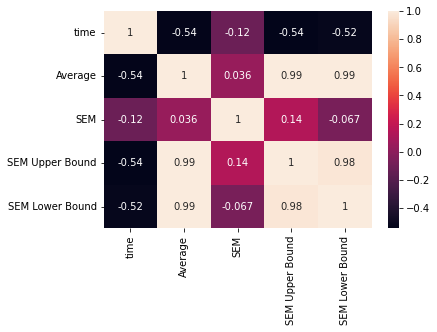

In [17]:
import seaborn as sb
import matplotlib.pyplot as mp

df = fiber_objs['Obj1'].PETS_data
df.head()
heatm = sb.heatmap(df.corr(), annot=True) 

mp.show()

In [ ]:
chan_1 = test_1.channels
chan_2 = test_2.channels
chan_3 = test_3.channels
print(chan_1)
print(chan_2)
print(chan_3)

{'Raw_Green', 'Normalized_Green', 'Raw_Red', 'Raw_Isosbestic'}
{'Raw_Green', 'Normalized_Isosbestic', 'Raw_Red', 'Raw_Isosbestic'}
{'Raw_Green', 'Normalized_Green', 'Raw_Red', 'Raw_Isosbestic'}


In [ ]:
intersect = list(set(chan_1) & set(chan_2))
print(intersect)
print(chan_1)
print(chan_2)

['Raw_Green', 'Raw_Red', 'Raw_Isosbestic']
{'Raw_Green', 'Normalized_Green', 'Raw_Red', 'Raw_Isosbestic'}
{'Raw_Green', 'Normalized_Isosbestic', 'Raw_Red', 'Raw_Isosbestic'}
obj2 starting at  2627.7480932499175


{'Raw_Green', 'Normalized_Green', 'Raw_Red', 'Raw_Isosbestic'}


In [ ]:
import inspect
from pprint import pprint
# pprint(inspect.getmembers(test_1))
# Step 1: Check if the lists have the same length
if len(chan_1) != len(chan_2):
    print(False)

# Step 2: Compare corresponding tuples
for tuple1, tuple2 in zip(chan_1, chan_2):
    if tuple1 != tuple2:
        print(False)
    else:
        print(True)

True
False
True
True


In [ ]:
channel = 'Normalized_Isosbestic'
beh = 'active interaction'
time_bef = 2
time_aft = 5

In [ ]:
poop = test_1.plot_PETS(channel, beh, time_bef, time_aft)
pyo.plot(poop, filename='Heatmap_plot.html')

In [ ]:
import numpy as np
def pets_HEAT(obj, channel, beh, time_before, time_after,
                    baseline = 0, base_option = 'Each event', show_first = 0,
                    show_last = -1, show_every = 1,
                    save_csv = False, percent_bool = False):
    try:
        full_time = obj.fpho_data_df['time_' + channel.split('_')[1]]
        time_name = 'time_' + channel.split('_')[1]
    except KeyError:
        full_time = obj.fpho_data_df['time']
        time_name = 'time'
    # Finds all times where behavior starts, turns into list
    beh_times = list(obj.fpho_data_df[(
        obj.fpho_data_df[beh]=='S')][time_name])
    if len(beh_times) < 2:
        print('There is 1 or less bouts of ' + beh + ' in ' + obj.obj_name)
        return
    # Initialize figure
    fig = make_subplots(rows = 1, cols = 2,
                        subplot_titles = ('Full trace with events',
                                          'Average'
                                         ))
    fig.add_trace(
        go.Heatmap(
        x = full_time,
        y = obj.fpho_data_df[channel],
        autocolorscale = True,  # You can choose a different color scale
        z = np.ones_like(full_time),  # Set the z values to 1 to represent point density
        name = channel,
        showscale=True),  # Display the color scale legend
        row = 1, col = 1
    )
    
    return fig

In [ ]:
poop_2 = pets_HEAT(test_1, channel, beh, time_bef, time_aft)
pyo.plot(poop_2, filename = 'heatmap_test.html')

In [ ]:

# Sample scatter data (x and y coordinates)
x_values = np.random.rand(100)
y_values = np.random.rand(100)


In [ ]:
heatmap = go.Heatmap(
    x=x_values,
    y=y_values,
    autocolorscale = True,  # You can choose a different color scale
    z=np.ones_like(x_values), # Set the z values to 1 to represent point density
    showscale=True  # Display the color scale legend
)


In [ ]:
layout = go.Layout(
    title='Heatmap of Scatter Data',
    xaxis=dict(title='X-axis Label'),
    yaxis=dict(title='Y-axis Label')
)


In [ ]:
fig = go.Figure(data=[heatmap], layout=layout)
pyo.plot(fig, filename = 'heatmap_test.html')